Single Variable Analysis

In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import math
import scipy.stats as stats


In [3]:
dct_file = "data/2002FemPreg.dct"
dat_file = "data/2002FemPreg.dat.gz"

In [4]:
class FixedWidthVariables(object):
    """Represents a set of variables in a fixed width file."""

    def __init__(self, variables, index_base=0):
        """Initializes.
        variables: DataFrame
        index_base: are the indices 0 or 1 based?
        Attributes:
        colspecs: list of (start, end) index tuples
        names: list of string variable names
        """
        self.variables = variables

        # note: by default, subtract 1 from colspecs
        self.colspecs = variables[['start', 'end']] - index_base

        # convert colspecs to a list of pair of int
        self.colspecs = self.colspecs.astype(np.int).values.tolist()
        self.names = variables['name']

    def ReadFixedWidth(self, filename, **options):
        """Reads a fixed width ASCII file.
        filename: string filename
        returns: DataFrame
        """
        df = pd.read_fwf(filename,
                             colspecs=self.colspecs, 
                             names=self.names,
                             **options)
        return df

In [5]:
def ReadStataDct(dct_file, **options):
    """Reads a Stata dictionary file.
    dct_file: string filename
    options: dict of options passed to open()
    returns: FixedWidthVariables object
    """
    type_map = dict(byte=int, int=int, long=int, float=float, 
                    double=float, numeric=float)

    var_info = []
    with open(dct_file, **options) as f:
        for line in f:
            match = re.search( r'_column\(([^)]*)\)', line)
            if not match:
                continue
            start = int(match.group(1))
            t = line.split()
            vtype, name, fstring = t[1:4]
            name = name.lower()
            if vtype.startswith('str'):
                vtype = str
            else:
                vtype = type_map[vtype]
            long_desc = ' '.join(t[4:]).strip('"')
            var_info.append((start, vtype, name, fstring, long_desc))
            
    columns = ['start', 'type', 'name', 'fstring', 'desc']
    variables = pd.DataFrame(var_info, columns=columns)

    # fill in the end column by shifting the start column
    variables['end'] = variables.start.shift(-1)
    variables.loc[len(variables)-1, 'end'] = 0

    dct = FixedWidthVariables(variables, index_base=1)
    return dct

In [6]:
def ReadFemResp(dct_file,
                dat_file,
                nrows=None):
    """Reads the NSFG respondent data.
    dct_file: string file name
    dat_file: string file name
    returns: DataFrame
    """
    dct = ReadStataDct(dct_file)
    df = dct.ReadFixedWidth(dat_file, compression='gzip', nrows=nrows)
    CleanFemPreg(df)
    return df

In [7]:
def CleanFemPreg(df):
    """Recodes variables from the pregnancy frame.
    df: DataFrame
    """
    # mother's age is encoded in centiyears; convert to years
    df.agepreg /= 100.0

    # birthwgt_lb contains at least one bogus value (51 lbs)
    # replace with NaN
    df.loc[df.birthwgt_lb > 20, 'birthwgt_lb'] = np.nan
    
    # replace 'not ascertained', 'refused', 'don't know' with NaN
    na_vals = [97, 98, 99]
    df.birthwgt_lb.replace(na_vals, np.nan, inplace=True)
    df.birthwgt_oz.replace(na_vals, np.nan, inplace=True)
    df.hpagelb.replace(na_vals, np.nan, inplace=True)

    df.babysex.replace([7, 9], np.nan, inplace=True)
    df.nbrnaliv.replace([9], np.nan, inplace=True)

    # birthweight is stored in two columns, lbs and oz.
    # convert to a single column in lb
    # NOTE: creating a new column requires dictionary syntax,
    # not attribute assignment (like df.totalwgt_lb)
    df['totalwgt_lb'] = df.birthwgt_lb + df.birthwgt_oz / 16.0    

    # due to a bug in ReadStataDct, the last variable gets clipped;
    # so for now set it to NaN
    df.cmintvw = np.nan

In [8]:
df_main = ReadFemResp(dct_file=dct_file, dat_file=dat_file)
df_main

,caseid,pregordr,howpreg_n,howpreg_p,moscurrp,nowprgdk,pregend1,pregend2,nbrnaliv,multbrth,...,laborfor_i,religion_i,metro_i,basewgt,adj_mod_basewgt,finalwgt,secu_p,sest,cmintvw,totalwgt_lb
0,1,1,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,3410.389399,3869.349602,6448.271112,2,9,NaN,8.8125
1,1,2,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,3410.389399,3869.349602,6448.271112,2,9,NaN,7.8750
2,2,1,NaN,NaN,NaN,NaN,5.0,NaN,3.0,5.0,...,0,0,0,7226.301740,8567.549110,12999.542264,2,12,NaN,9.1250
3,2,2,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,7226.301740,8567.549110,12999.542264,2,12,NaN,7.0000
4,2,3,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,7226.301740,8567.549110,12999.542264,2,12,NaN,6.1875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13588,12571,1,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,4670.540953,5795.692880,6269.200989,1,78,NaN,6.1875
13589,12571,2,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,...,0,0,0,4670.540953,5795.692880,6269.200989,1,78,NaN,NaN
13590,12571,3,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,...,0,0,0,4670.540953,5795.692880,6269.200989,1,78,NaN,NaN
13591,12571,4,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,4670.540953,5795.692880,6269.200989,1,78,NaN,7.5000


In [9]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13593 entries, 0 to 13592
Columns: 244 entries, caseid to totalwgt_lb
dtypes: float64(171), int64(73)
memory usage: 25.3 MB


In [10]:
df_main.describe()

,caseid,pregordr,howpreg_n,howpreg_p,moscurrp,nowprgdk,pregend1,pregend2,nbrnaliv,multbrth,...,laborfor_i,religion_i,metro_i,basewgt,adj_mod_basewgt,finalwgt,secu_p,sest,cmintvw,totalwgt_lb
count,13593.000000,13593.000000,352.000000,349.00000,352.000000,3.000000,13241.000000,18.000000,9144.000000,163.000000,...,13593.000000,13593.000000,13593.0,13593.000000,13593.000000,13593.000000,13593.000000,13593.000000,0.0,9038.000000
mean,6216.526595,2.349150,15.144886,1.34384,4.647727,3.666667,4.650177,4.055556,1.022419,1.834356,...,0.000809,0.003016,0.0,4216.271164,5383.982581,8196.422280,1.487310,44.083352,NaN,7.265628
std,3645.417341,1.577807,13.922211,0.47567,2.527523,4.618802,1.849790,1.696787,0.190098,1.630208,...,0.028437,0.058727,0.0,3982.680473,5640.499431,9325.918114,0.499857,24.110403,NaN,1.408293
min,1.000000,1.000000,0.000000,1.00000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.0,64.577101,71.201194,118.656790,1.000000,1.000000,NaN,0.125000
25%,3022.000000,1.000000,5.000000,1.00000,2.000000,1.000000,3.000000,3.000000,1.000000,1.000000,...,0.000000,0.000000,0.0,2335.445237,2798.048902,3841.375308,1.000000,25.000000,NaN,6.500000
50%,6161.000000,2.000000,9.000000,1.00000,5.000000,1.000000,6.000000,4.000000,1.000000,1.000000,...,0.000000,0.000000,0.0,3409.648504,4127.220642,6256.592133,1.000000,45.000000,NaN,7.375000
75%,9423.000000,3.000000,23.000000,2.00000,7.000000,5.000000,6.000000,6.000000,1.000000,1.000000,...,0.000000,0.000000,0.0,4869.941451,5795.692880,9432.360931,2.000000,65.000000,NaN,8.125000
max,12571.000000,19.000000,99.000000,2.00000,9.000000,9.000000,9.000000,6.000000,5.000000,5.000000,...,1.000000,2.000000,0.0,99707.832014,157143.686687,261879.953864,2.000000,84.000000,NaN,15.437500


In [11]:
df_main.columns.all

<bound method Index._add_logical_methods.<locals>._make_logical_function.<locals>.logical_func of Index(['caseid', 'pregordr', 'howpreg_n', 'howpreg_p', 'moscurrp', 'nowprgdk',
       'pregend1', 'pregend2', 'nbrnaliv', 'multbrth',
       ...
       'laborfor_i', 'religion_i', 'metro_i', 'basewgt', 'adj_mod_basewgt',
       'finalwgt', 'secu_p', 'sest', 'cmintvw', 'totalwgt_lb'],
      dtype='object', length=244)>

In [12]:
df_main.howpreg_n.isnull().sum()

13241

In [13]:
df_main.prgoutcome.isnull().sum()

38

In [14]:
df_main.prgoutcome.value_counts()

1.0    9148
2.0    4055
3.0     352
Name: prgoutcome, dtype: int64

In [15]:
live = df_main[df_main.prgoutcome == 1]

In [16]:
len(live)

9148

Text(0, 0.5, 'frequency')

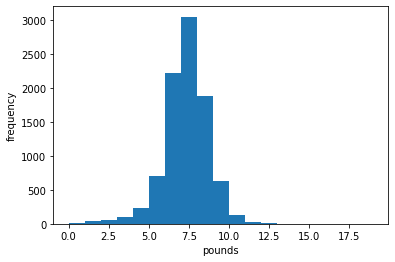

In [17]:
plt.hist(live.birthwgt_lb, label='birthwgt_lb', bins=range(0,20,1))
plt.xlabel("pounds")
plt.ylabel("frequency")

Text(0, 0.5, 'frequency')

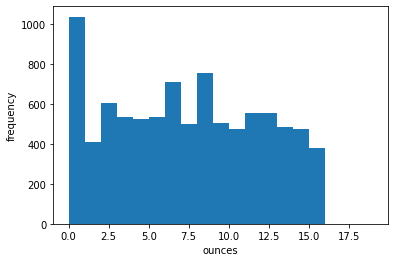

In [18]:
plt.hist(live.birthwgt_oz, label='birthwgt_oz', bins=range(0,20,1))
plt.xlabel("ounces")
plt.ylabel("frequency")

Text(0, 0.5, 'frequency')

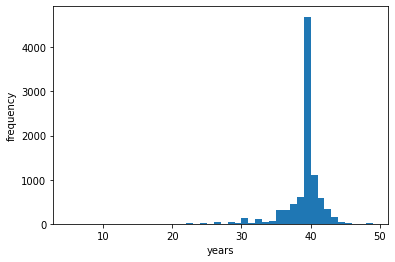

In [19]:
plt.hist(live.prglngth, label='prglngth', bins=range(5,50,1))
plt.xlabel("years")
plt.ylabel("frequency")

Text(0, 0.5, 'frequency')

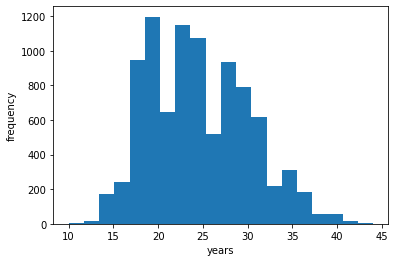

In [20]:
plt.hist(np.floor(live.agepreg), label='agepreg', bins=20)
plt.xlabel("years")
plt.ylabel("frequency")

In [21]:
firsts = live[live.birthord == 1]
others = live[live.birthord != 1]

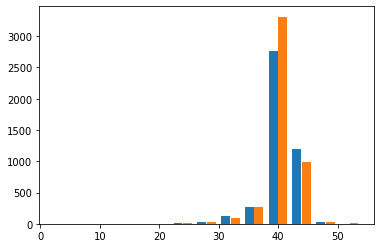

In [22]:
plt.hist([firsts.prglngth, others.prglngth], width=1.5, align='right', bins=range(0, 55, 4))
plt.show()

The CDF is the function that maps from a value to its percentile rank. 
The CDF is a function of x where x is any value that might appear in distribution

In [23]:
def cdf(data, mark):
    count = 0
    for i in data:
        if i <= mark :
            count+= 1
    
    return count/ len(data)

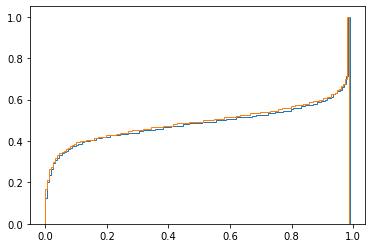

In [24]:
plt.hist([cdf(firsts.totalwgt_lb, i) for i in np.linspace(0,15,150)] ,bins = 150, density=True, cumulative=True, label='CDF', histtype='step')
plt.hist([cdf(others.totalwgt_lb, i) for i in np.linspace(0,15,150)] ,bins = 150, density=True, cumulative=True, label='CDF', histtype='step')

plt.show()

Text(0, 0.5, 'frequency')

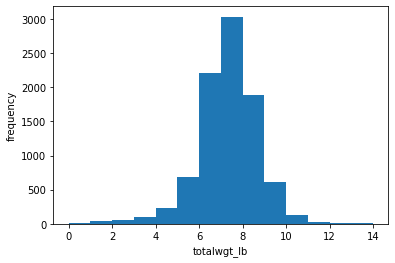

In [25]:
plt.hist(live.totalwgt_lb, label='weights', bins=range(0,15,1))
plt.xlabel("totalwgt_lb")
plt.ylabel("frequency")

MODELING DISTRIBUTION

In [26]:
def MakeNormalPlot(weights, term_weights):
    """Generates a normal probability plot of birth weights."""

    mean, var = util_stat.TrimmedMeanVar(weights, p=0.01)
    std = math.sqrt(var)

    xs = [-4, 4]
    fxs, fys = util_stat.FitLine(xs, mean, std)
    plt.plot(fxs, fys, linewidth=4, color='0.8')

    #util_plot.PrePlot(2) 
    xs, ys = util_stat.NormalProbability(weights)
    plt.plot(xs, ys, label='all live')

    xs, ys = util_stat.NormalProbability(term_weights)
    plt.plot(xs, ys, label='full term')
    # util_plot.Save(root='analytic_birthwgt_normal',
    #                title='Normal probability plot',
    #                xlabel='Standard deviations from mean',
    #                ylabel='Birth weight (lbs)')

In [27]:
import util_stat, util_plot

def MakeNormalModel(weights):
    """Plot the CDF of birthweights with a normal model."""
    
    # estimate parameters: trimming outliers yields a better fit
    mu, var = util_stat.TrimmedMeanVar(weights, p=0.01)
    print('Mean, Var', mu, var)
    
    # plot the model
    sigma = math.sqrt(var)
    print('Sigma', sigma)
    xs, ps = util_stat.RenderNormalCdf(mu, sigma, low=0, high=12.5)

    plt.plot(xs, ps, label='model', color='0.8')

    # plot the data
    cdf = util_stat.Cdf(weights, label='data')

    util_plot.PrePlot(1)
    plt.plot(cdf.xs, cdf.ps)
    #util_plot.Cdf(cdf) 

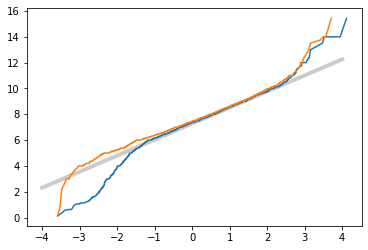

In [28]:
full_term = df_main[df_main.prglngth >= 37]
weights = df_main.totalwgt_lb.dropna()
term_weights = full_term.totalwgt_lb.dropna()
MakeNormalPlot(weights, term_weights)

CDF of birthweight (blue) fit a normal model (grey)

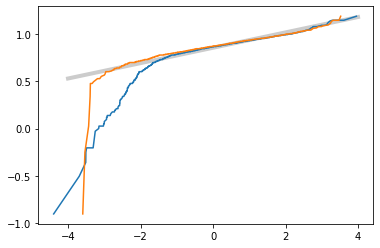

In [29]:
#child weight
MakeNormalPlot(np.log10(weights), np.log10(term_weights))

Mean, Var 7.280883100022579 1.5452125703544897
Sigma 1.2430657948614343


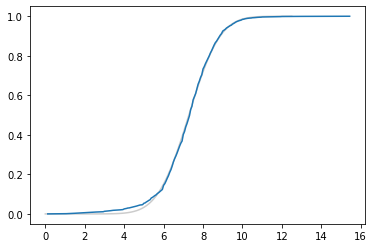

In [30]:
MakeNormalModel(weights)

Mean, Var 0.8550971035123834 0.0066140813967214334
Sigma 0.08132700287556055


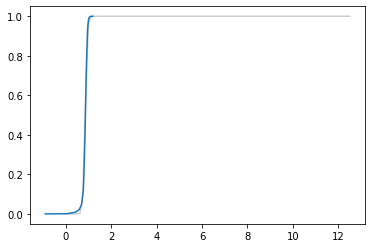

In [31]:
MakeNormalModel(np.log10(weights))

PERATO DISTRIBUTION

In [32]:
import random

In [33]:
random_weibull = [random.weibullvariate(alpha=3, beta=1) for _ in range(10000)]

In [34]:
random_weibull

[1.5179954563368665,
 6.384283323144203,
 4.644876011704151,
 4.919423686757739,
 6.717351464303037,
 1.544991978837671,
 4.151118065148115,
 0.7560378656043943,
 2.0856053983173455,
 6.706053164735752,
 0.8713665447537251,
 5.367490699321518,
 8.275844591223613,
 1.576610434322421,
 0.26900765382228875,
 0.6619914564823458,
 2.589275063812975,
 1.4452326997538185,
 7.769752760206847,
 1.1022052424974662,
 0.3705420448890631,
 1.7560788130396525,
 1.3889882732517047,
 0.19091643511980763,
 4.590991778727366,
 1.0266711464223814,
 0.5977155174969371,
 0.8827256622265209,
 0.07430174794273835,
 4.918772460200359,
 1.9750930134725004,
 0.39619417397043605,
 0.28837561937447365,
 4.223382310599449,
 11.039915977603568,
 0.4805471009370059,
 1.3094939716035312,
 1.110285154076997,
 0.08661563495845134,
 0.15515716400672283,
 0.8252439373177325,
 2.215414276520745,
 2.090534663418469,
 3.498408145339689,
 1.2039975898221935,
 0.2305887009422952,
 2.8580642058137453,
 1.2900833925851014,
 0.8

{'xscale': 'log', 'yscale': 'log'}

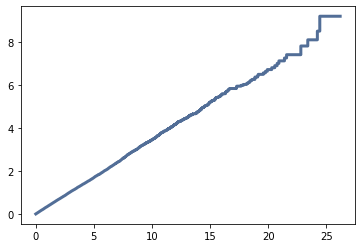

In [35]:
cdf = util_stat.Cdf(random_weibull)
util_plot.Cdf(cdf, transform='weibull')

In [36]:
#Ex05. Get the data from original repo from author, read it and plot cdf (actual). generate random numbers from exponential distribution (model). Compare between
#below is not exact
random_expo = [random.expovariate(lambd=1) for _ in range(43)]

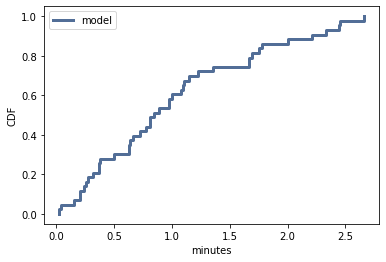

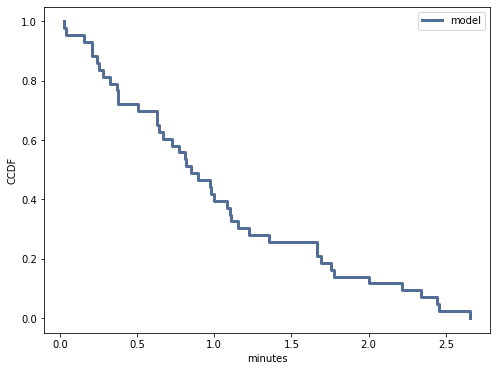

<Figure size 576x432 with 0 Axes>

In [37]:
cdf = util_stat.Cdf(random_expo, label='model')
util_plot.Cdf(cdf)
util_plot.Show(xlabel='minutes', ylabel='CDF')

cdf_com = util_stat.Cdf(random_expo, label='model')
util_plot.Cdf(cdf_com, complement=True)
util_plot.Show(xlabel='minutes', ylabel='CCDF')


In [45]:
df_main = df_main.dropna(subset=['totalwgt_lb', 'agepreg'])

In [46]:
df_main.shape

(9038, 244)

Text(0.5, 0, 'mother age')

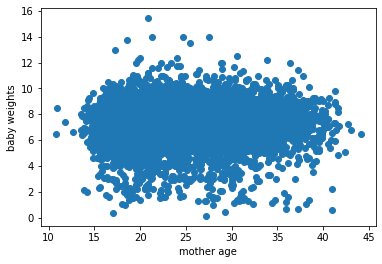

In [50]:
weights = df_main.totalwgt_lb
mother_age = df_main.agepreg

plt.scatter(mother_age, weights)
plt.ylabel('baby weights')
plt.xlabel('mother age')

In [51]:
bins = np.arange(10, 45, 5)
indices = np.digitize(df_main.agepreg, bins)
groups = df_main.groupby(indices)

In [57]:
# height mark. this is mean of heights for each groups
ages = [group.agepreg.mean() for i , group in groups]
cdfs = [util_stat.Cdf(group.totalwgt_lb) for i, group in groups]

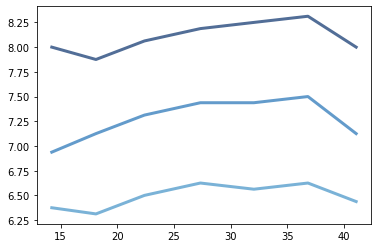

In [58]:
"""
We want to know at which weight, cdf value of a height makes up .75, .5, .25 of all samples
"""
percentiles = [75, 50, 25]
for percent in percentiles:
    weights = [cdf.Percentile(percent) for cdf in cdfs]
    util_plot.Plot(ages, weights)
    

In [59]:
util_stat.Corr(df_main.totalwgt_lb, df_main.agepreg)

0.06883397035410904

In [60]:
util_stat.SpearmanCorr(df_main.totalwgt_lb, df_main.agepreg)

0.09461004109658226